### GAMALOS (GAlaxies MAking LOve Simulation)

Report: write a short report containing:
- a short introduction to the N-body problem, the difference between
collisional and collisionless systems and the force estimate in
collisionless simulations based on tree algorithms. Short general
description of the fireworks package and its implementation.
- Description of the methods (integrators, force estimator) used.
- Description of the initial conditions and simulation setup.
- Results and discussion. They depends on the specific project you
chose, but I expect at least one plot showing the main conclusion of
your analysis.

<div class='alert alert-danger' role='alert'>
Inserisci info teoriche
</div>

### Computation

In [1]:
#first of all, we import all the packages for Particles, integrators, ic...

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from fireworks.nbodylib.integrators import integrator_leapfrog, integrator_leapfrog_galaxy, integrator_rungekutta, integrator_tsunami
from fireworks.nbodylib.dynamics import acceleration_pyfalcon, acceleration_jerk_direct
from fireworks.nbodylib.timesteps import adaptive_timestep_r
from fireworks.particles import Particles
from typing import Optional, Tuple, Callable, Union
import time

#from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

We can import the data of one galaxy at first. The units are still Nbody units.

In [2]:
df_0 = pd.read_csv("data_cvs/Nbody_disc.csv")

# Slicing the dataframe to reduce computation time
num_particles = 100
df = df_0.iloc[:num_particles]

df.head(10)

,mass,x,y,z,vx,vy,vz
0,1.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,1.000000e-11,-3.419583,-1.901788,0.0,0.118878,-0.213752,0.0
2,1.000000e-11,-14.046839,-2.403541,0.0,0.040952,-0.239330,0.0
3,1.000000e-11,-4.618003,6.269821,0.0,-0.222721,-0.164044,0.0
4,1.000000e-11,-6.045516,0.257974,0.0,-0.011730,-0.274897,0.0
5,1.000000e-11,-1.393104,1.578234,0.0,-0.124900,-0.110249,0.0
6,1.000000e-11,-1.150877,-1.762433,0.0,0.139480,-0.091081,0.0
7,1.000000e-11,0.593887,-1.003781,0.0,0.086283,0.051049,0.0
8,1.000000e-11,2.423492,-10.266498,0.0,0.257402,0.060762,0.0
9,1.000000e-11,-3.279328,5.118040,0.0,-0.231783,-0.148512,0.0


In [3]:
#I create a class with the mass, pos, vel of each element of the Galaxy

masses = df[['mass']]
positions = df[['x', 'y', 'z']]
velocities = df[['vx', 'vy', 'vz']]

# reshape mass array to 1D array (required by pyfalcon)
masses = masses.values.reshape(-1)
print(masses.shape)

Galaxy1 = Particles(positions.values, velocities.values, masses)

(100,)


In [4]:
#I can do the same for the other Galaxy. This second galaxy is the same as the first one, but translated by a certain value. In particular I have
pos_translation = np.array((40., 20., 0.))
vel_translation = np.array((-0.2, 0., 0.))

#So, I just apply this translation to find the second galaxy
positions_gal_2 = positions.values + pos_translation
velocities_gal_2 = velocities.values + vel_translation
Galaxy2 = Particles(positions_gal_2, velocities_gal_2, masses)

plot the first galaxy

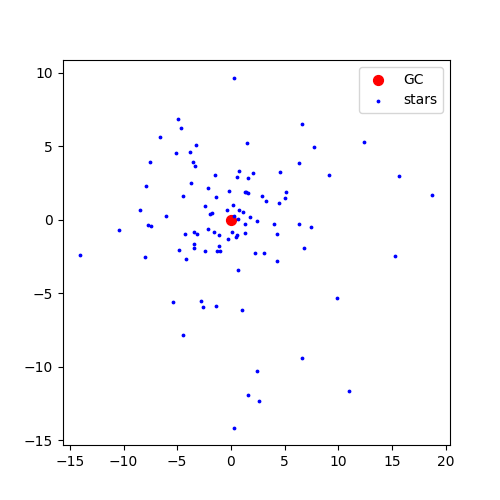

In [5]:
plt.figure(figsize=(5,5))
plt.scatter(Galaxy1.pos[0,0], Galaxy1.pos[0,0], label='GC', s=50, color='red')
plt.scatter(Galaxy1.pos[1:,0], Galaxy1.pos[1:,1], label='stars', s=3, color='blue')
plt.legend()
plt.show()

### Now let's try to run a test orbit simulation with pyfalcon:

Let's try an orbital simulation of the first galaxy to see if the integration works (in this test we used the leap-frog method)

In [6]:
# First we calculate the period of the galaxy (approximatly, I'm not sure if is the right method)
# with the formula T = 2*pi*sqrt(a^3/GM).
# We're in n-body units so G=1 and for the radius I take the maximum distance from the centre of the galaxiy (a = r_max)
# and we suppose a cicurlar orbits so e=0

plummer_scale_lenght = 5.              # scale lenght of the plummer sphere
e = 0.                                  # eccentricity
radius = np.max(Galaxy1.radius())       # radius of the galaxy
print(f'radius of the galaxy: {radius}')

a = radius / (1 - e)                    # semi-major axis
M = Galaxy1.mass[0]                     # taking the mass of center of mass

T = 2*np.pi*np.sqrt(a**3/M)             # period of the galaxy

print(f'Period of the galaxy (approximately): {T}')

# Now we can define the time of simulation and the number of steps
t0 = 0.                         # initial time
tsimulation = 1*T              # time of simulation
N = int(1e4)                    # number of steps
h = (tsimulation - t0)/N        # time steps


def integration_leapfrog_adaptive(galaxy: Particles, h: float, tsimulation: float, t: float, soft: float):

    N = len(galaxy.mass)         # number of particles in the galaxy
    path = [galaxy.pos]
    time   = [t]
    timestep = [h]
    
    Etot_leapfrog = []
    Ekin_leapfrog = []
    Epot_leapfrog = []

    while t < tsimulation:
        result = integrator_leapfrog_galaxy(particles=galaxy, tstep=h, acceleration_estimator=acceleration_pyfalcon, softening=soft)
        updated_galaxy, updated_acc, _, _ = result
        path.append(updated_galaxy.pos)
            
        Etot_n, Ekin_n, Epot_n = updated_galaxy.Etot_vett()
        Etot_leapfrog.append(Etot_n)
        Ekin_leapfrog.append(Ekin_n)
        Epot_leapfrog.append(Epot_n)
        
        #ts_1, _, _ = adaptive_timestep_r(galaxy)
        #h = ts_1
        timestep.append(h)
        t += h
        time.append(t)


    path = np.array(path)
    time   = np.array(time)
    time2  = np.array(timestep)

    Etot_leapfrog = np.array(Etot_leapfrog)
    Ekin_leapfrog = np.array(Ekin_leapfrog)
    Etot_leapfrog = np.array(Epot_leapfrog)

    return path, Etot_leapfrog, Ekin_leapfrog, Epot_leapfrog, time, timestep
                                                                                          

radius of the galaxy: 18.850103791393835
Period of the galaxy (approximately): 514.221803394768


In [7]:
Galaxy1_test = Galaxy1.copy()

Galaxy1_orbit, Galaxy1_Etot, Galaxy1_Ekin, Galaxy1_Epot, Galaxy1_time, Galaxy1_timestep = integration_leapfrog_adaptive(galaxy=Galaxy1_test, h=h, 
                                                                                            tsimulation=tsimulation, t=t0, soft=plummer_scale_lenght)

/root/miniconda3/lib/python3.10/site-packages/fireworks-0.0.5-py3.10.egg/fireworks/particles.py:275: RuntimeWarning: divide by zero encountered in divide


Now let's try to print the particles evolution within a Period time

/root/miniconda3/lib/python3.10/site-packages/ipympl/backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


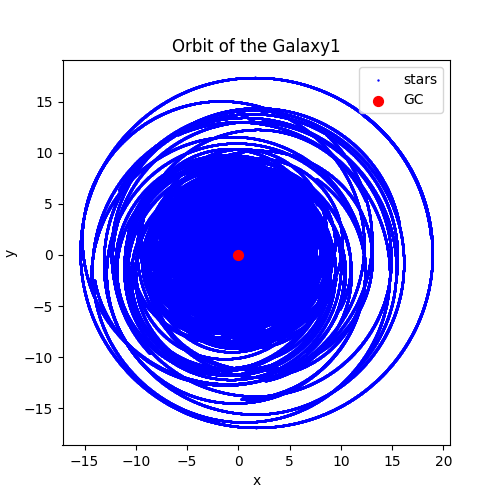

In [8]:
plt.figure(figsize=(5,5))
plt.scatter(Galaxy1_orbit[:,1:,0], Galaxy1_orbit[:,1:,1], s=0.5, color='blue', label='stars')
plt.scatter(Galaxy1_orbit[0,0,0], Galaxy1_orbit[0,0,1], s=50, color='red', label='GC')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Orbit of the Galaxy1')
plt.legend()
plt.show()

Let's see the Total Energy Error of our simulation. First we define the *general function*

In [9]:
def total_energy_error(Etot, initial_t, tsimulation, h):
    energy_error = np.zeros_like(Etot)

    for i in range(len(Etot)):
        energy_error[i] = np.abs((Etot[i] - Etot[0])/Etot[0])

    time = np.arange(0, tsimulation, h)

    return energy_error, time

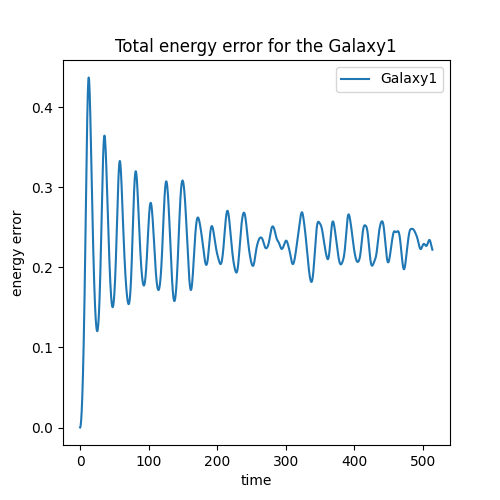

In [10]:
# I calculate the error of the total energy for the Galaxy1

energy_error, time = total_energy_error(Etot=Galaxy1_Etot, initial_t=t0, tsimulation=tsimulation, h=h)


# Now I can plot the error of the total energy for the Galaxy1
plt.figure(figsize=(5,5))
plt.plot(time, energy_error, label='Galaxy1')
plt.xlabel('time')
plt.ylabel('energy error')
plt.title('Total energy error for the Galaxy1')
plt.legend()
plt.show()